<a href="https://colab.research.google.com/github/tlsehdgns1999/tlsehdgns1999/blob/main/airline_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **주제 선정 배경**

    여름철은 관광객의 수요가 증가하는 시기로, 많은 사람들이 휴가나 여행을 계획하고 항공을 이용한다. 하지만 항공 여정 중에 발생하는 지연은 여행자들에게 큰 불편을 야기할 수 있다. 항공기 지연은 여행 일정의 변경, 연결 항공편 캔슬, 예약된 호텔, 일정의 충돌 등의 문제를 일으킬 수 있으며, 여행의 즐거움을 크게 해치는 요소로 작용할 수 있다.

    이러한 문제를 인식한 항공사들은 관광객의 불편을 최소화하고 만족도를 높이기 위해 항공기 지연 예측을 실시하고 있다. 항공기 지연 예측은 과거 데이터, 기상 정보, 항공기 운항 정보, 공항 상황 등을 종합적으로 분석하여 항공기가 지연될 가능성을 예측하는 방법이다. 이를 통해 항공사는 여행자들에게 사전에 지연 정보를 알려줌으로써 여행 일정 조정이나 대체 옵션 제공 등으로 불편을 최소화할 수 있게된다.



본 데이터는 데이콘 '항공기 지연 예측' 데이터임을 알리고 예측 타겟은 Dealy이다. 


    URL = https://dacon.io/competitions/official/236094/data

In [ ]:
### 필요 모듈 불러오기

import pandas as pd
import numpy as np
import os
import gc
from scipy.stats import mode
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

#    **parquet** - 컬럼 전체를 압축해 클라우드 환경에 저장한다. 빅데이터 처리에 적합하다.



In [ ]:
def csv_to_parquet(csv_path, save_name):
     df = pd.read_csv(csv_path)
     df.to_parquet(f'./{save_name}.parquet')
     del df
     gc.collect()
     print(save_name, 'Done.')

train_path = '/content/drive/MyDrive/Colab Notebooks/dakondata/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/dakondata/test.csv'

csv_to_parquet(train_path, 'train')
csv_to_parquet(test_path, 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dakondata/sample_submission.csv', index_col = 0)

train Done.
test Done.


간단한 train set의 형을 알아보자.

# ***train set 전처리***

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
train.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,TRAIN_000000,TRAIN_000001,TRAIN_000002,TRAIN_000003,TRAIN_000004,TRAIN_000005,TRAIN_000006,TRAIN_000007,TRAIN_000008,TRAIN_000009,TRAIN_000010,TRAIN_000011,TRAIN_000012,TRAIN_000013,TRAIN_000014,TRAIN_000015,TRAIN_000016,TRAIN_000017,TRAIN_000018,TRAIN_000019
Month,4,8,9,7,1,4,1,4,6,6,8,3,1,9,12,11,4,8,8,7
Day_of_Month,15,15,6,10,11,13,20,20,13,6,13,18,12,19,18,18,5,10,11,14
Estimated_Departure_Time,NaN,740.0,1610.0,905.0,900.0,1545.0,1742.0,1815.0,1420.0,650.0,1730.0,600.0,1015.0,615.0,845.0,1355.0,1111.0,1400.0,1215.0,1907.0
Estimated_Arrival_Time,NaN,1024.0,1805.0,1735.0,1019.0,NaN,1903.0,1955.0,1550.0,838.0,1844.0,748.0,1145.0,706.0,855.0,1532.0,1412.0,1624.0,1258.0,2145.0
Cancelled,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diverted,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Origin_Airport,OKC,ORD,CLT,LAX,SFO,EWR,EWR,ORD,BWI,LIT,DCA,PHL,CLE,MAF,PHX,PIT,SFO,EWR,CRW,BDL
Origin_Airport_ID,13851,13930,11057,12892,14771,11618,11618,13930,10821,12992,11278,14100,11042,13158,14107,14122,14771,11618,11146,10529
Origin_State,Oklahoma,Illinois,North Carolina,California,California,None,New Jersey,Illinois,None,Arkansas,Virginia,Pennsylvania,Ohio,Texas,Arizona,Pennsylvania,California,New Jersey,None,Connecticut


#  train 결측치 시각화 #1

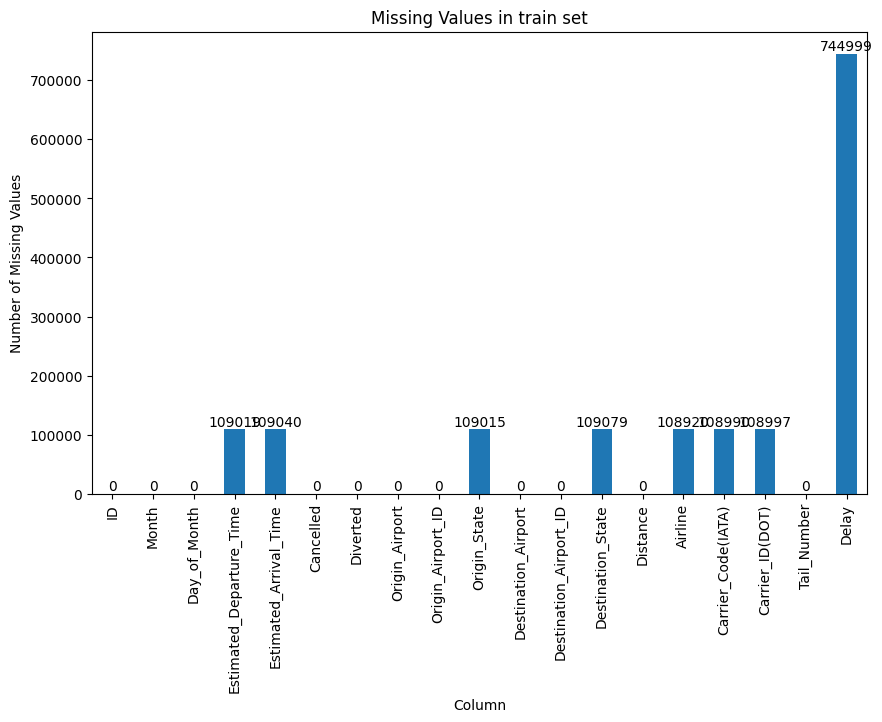

In [ ]:
train_fill = train[train.columns]

missing_values = train_fill.isnull().sum()

missing_values.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in train set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

Airline 과 Carrier_ID(DOT)는 각각 공항과 공항사의 고유 ID이다. 그래도 모르니 한 번 더 살펴본다.

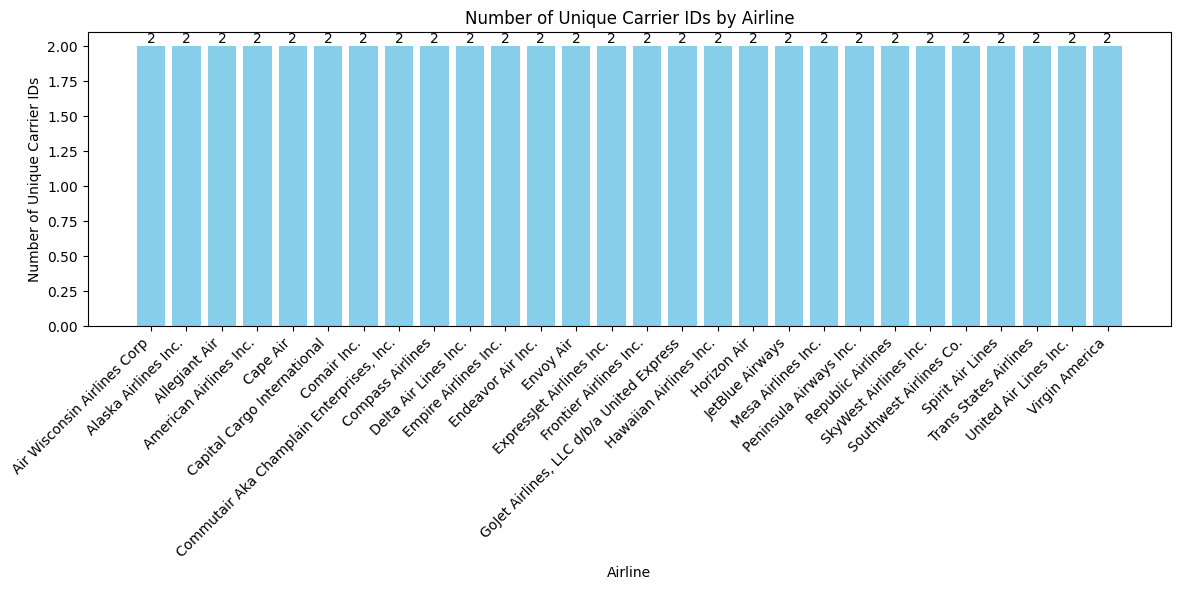

In [ ]:
grouped_data_byAirline = train.groupby('Airline')['Carrier_ID(DOT)'].unique()

airlines = []
carrier_ids = []

for airline, carrier_id in grouped_data_byAirline.items():
    airlines.append(airline)
    carrier_ids.append(carrier_id)

plt.figure(figsize=(12, 6))
plt.bar(airlines, [len(ids) for ids in carrier_ids], color='skyblue')
plt.xlabel('Airline')
plt.ylabel('Number of Unique Carrier IDs')
plt.title('Number of Unique Carrier IDs by Airline')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate([len(ids) for ids in carrier_ids]):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Airline 과 arrier_ID(DOT) 의 개수를 살펴보니 2개가 나오는 것을 알 수 있다. 분명 일대일 대응 되는 고유의 지표라고 알고 있었는데 정확한 형태를 위해 다음 코드를 작성했다.

In [ ]:
 ### 아래는 'Carrier_ID(DOT)' 는 'Airline'에 일대일 대응되는 지표임을 보여주는 코드

grouped_data_byAirline = train.groupby('Airline')['Carrier_ID(DOT)'].unique()

for airline, carrier_ids in grouped_data_byAirline.items():
    print(f"Airline: {airline}")
    print(f"Carrier_ID(DOT): {carrier_ids}")

Airline: Air Wisconsin Airlines Corp
Carrier_ID(DOT): [20046.    nan]
Airline: Alaska Airlines Inc.
Carrier_ID(DOT): [19930.    nan]
Airline: Allegiant Air
Carrier_ID(DOT): [20368.    nan]
Airline: American Airlines Inc.
Carrier_ID(DOT): [19805.    nan]
Airline: Cape Air
Carrier_ID(DOT): [20253.    nan]
Airline: Capital Cargo International
Carrier_ID(DOT): [20427.    nan]
Airline: Comair Inc.
Carrier_ID(DOT): [20397.    nan]
Airline: Commutair Aka Champlain Enterprises, Inc.
Carrier_ID(DOT): [20445.    nan]
Airline: Compass Airlines
Carrier_ID(DOT): [21167.    nan]
Airline: Delta Air Lines Inc.
Carrier_ID(DOT): [19790.    nan]
Airline: Empire Airlines Inc.
Carrier_ID(DOT): [20263.    nan]
Airline: Endeavor Air Inc.
Carrier_ID(DOT): [   nan 20363.]
Airline: Envoy Air
Carrier_ID(DOT): [20398.    nan]
Airline: ExpressJet Airlines Inc.
Carrier_ID(DOT): [20366.    nan]
Airline: Frontier Airlines Inc.
Carrier_ID(DOT): [20436.    nan]
Airline: GoJet Airlines, LLC d/b/a United Express
Carrier_

두 개의 값을 갖는 이유는 각각의 항공사마다 결측값이 꼭 한 개씩은 있어서임을 알 수 있다. 결국 일대일대응 되는 지표가 맞다는 것을 확인할 수 있다. 

In [ ]:
### 일대일 대응 되는 지표가 있으면 대체 하는 과정

carrier_code_mapping = train.groupby('Airline')['Carrier_ID(DOT)'].apply(lambda x: x.mode().iloc[0])
train['Carrier_ID(DOT)'] = train['Carrier_ID(DOT)'].fillna(train['Airline'].map(carrier_code_mapping))

In [ ]:
### 각각의 컬럼에 대해 한 번씩 시행

airline_code_mapping = train.groupby('Carrier_ID(DOT)')['Airline'].apply(lambda x: x.mode().iloc[0])
train['Airline'] = train['Airline'].fillna(train['Carrier_ID(DOT)'].map(airline_code_mapping))

    train 프레임을 살펴보면 달과 일 ((ex) Month = 4, Date = 11) 형식으로 되어있는 것을 볼 수 있다. 이런 형식으로 학습모델을 구성하면 모델의 복잡도가 높아지고 실행시간이 오래 걸릴 것으로 예상된다. 
    
    이 문제를 해결함과 동시에 두 컬럼을 한 개로 합쳐 컬럼을 줄일 수 있는 일거양득의 시간을 가져보자!

In [ ]:
### Month 와 Date를 한 가지의 days 컬럼으로 합치는 과정 (train, test 적용)

def days(x) :
    month_days = {1:0, 2:31, 3:60, 4:91, 5:121, 6:152, 7:182, 8:213, 9:244, 10:274, 11:305, 12:335}
    return month_days[x]

df_list = [train, test]
for i in range(len(df_list)) :
    df_list[i].loc[:, 'Day'] = train['Month'].apply(lambda x : days(x))
    df_list[i]['Day'] = df_list[i]['Day'] + df_list[i]['Day_of_Month']

train = train.astype({'Day': object})
test = test.astype({'Day': object})

### 'Month', 'Date' 컬럼 제거
### 기존 train 과 test 가 어떻게 쓰일지 모르기 때문에 _new 를 붙혀 새로운 데이터 프레임으로 생성 해 준다.

train_new = train.drop([train.columns[1], train.columns[2]], axis = 1)
test_new = test.drop([test.columns[1], test.columns[2]], axis = 1)

아래를 살펴보면 알맞게 잘 들어간 것을 확인해 볼 수 있다.

In [ ]:
train_new.head().T

,0,1,2,3,4
ID,TRAIN_000000,TRAIN_000001,TRAIN_000002,TRAIN_000003,TRAIN_000004
Estimated_Departure_Time,NaN,740.0,1610.0,905.0,900.0
Estimated_Arrival_Time,NaN,1024.0,1805.0,1735.0,1019.0
Cancelled,0,0,0,0,0
Diverted,0,0,0,0,0
Origin_Airport,OKC,ORD,CLT,LAX,SFO
Origin_Airport_ID,13851,13930,11057,12892,14771
Origin_State,Oklahoma,Illinois,North Carolina,California,California
Destination_Airport,HOU,SLC,LGA,EWR,ACV
Destination_Airport_ID,12191,14869,12953,11618,10157


#  train 결측치 시각화 #2

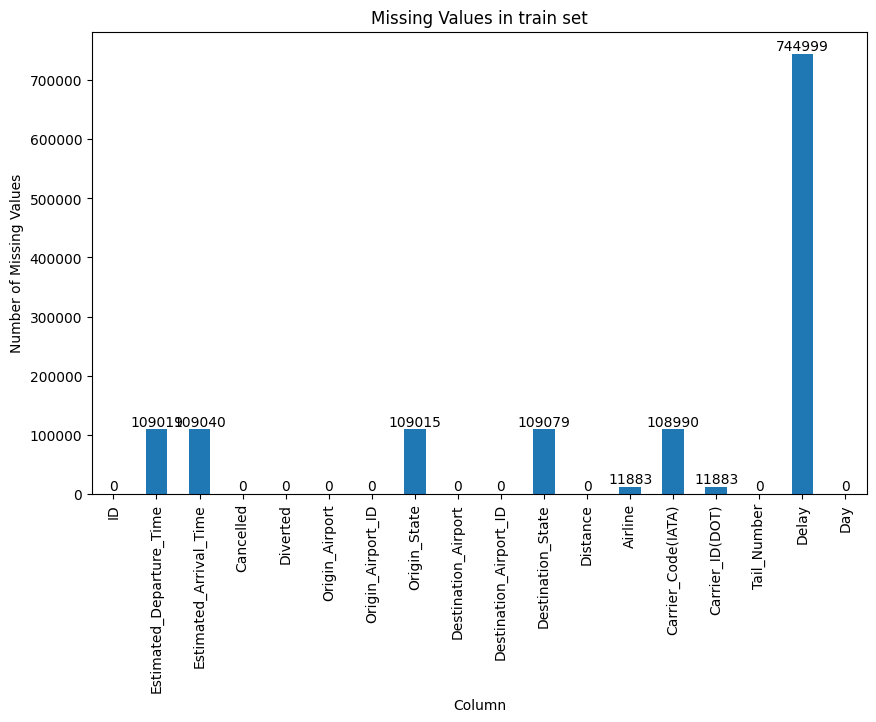

In [ ]:
### train set 의 결측값 시각화

train_new_fill = train_new[train_new.columns]

missing_values = train_new_fill.isnull().sum()

missing_values.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in train set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

'Carrier_ID(DOT)'와 'Airline' 의 결측치 약 100,000 -> 약 12,000 로 줄어든 것을 확인했다. 그렇다면 나머지는 둘 다 값이 없는 데이터라는 것을 자동적으로 알 수 있다.

In [ ]:
### train set 이므로 남는 Carrier_ID(DOT)는 전부 제거

train_new = train_new.dropna(subset = ['Carrier_ID(DOT)'], how='any', axis = 0)

다시 한 번 확인 해 보자

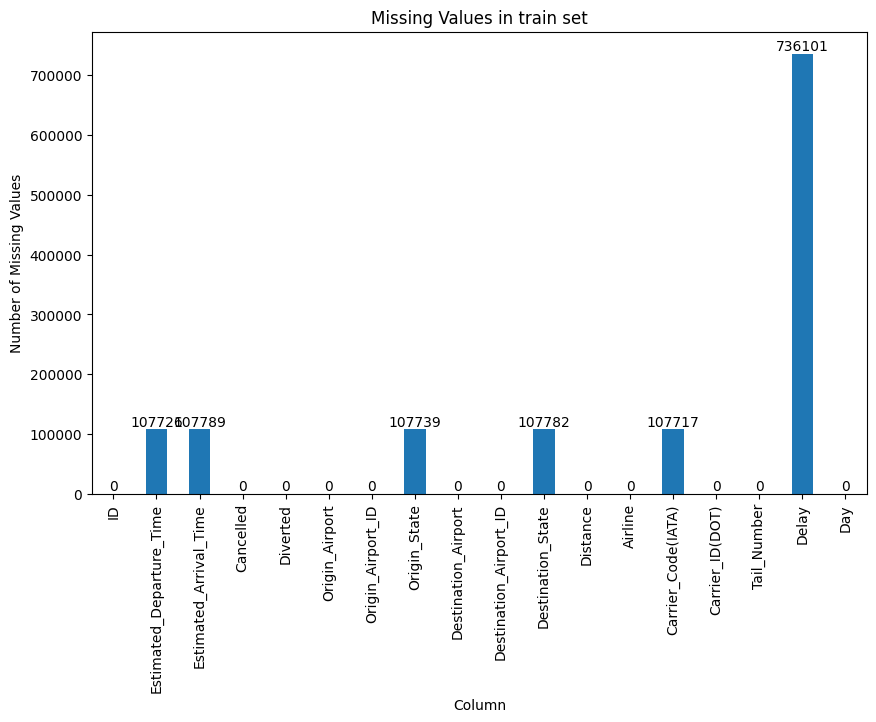

In [ ]:
train_new_fill = train_new[train_new.columns]

missing_values = train_new_fill.isnull().sum()

missing_values.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in train set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

더 제거할 수 있는 컬럼이 있을까?? 확인 해 보자

In [ ]:
train_new.nunique()

ID                          988117
Estimated_Departure_Time      1365
Estimated_Arrival_Time        1428
Cancelled                        1
Diverted                         1
Origin_Airport                 374
Origin_Airport_ID              374
Origin_State                    52
Destination_Airport            375
Destination_Airport_ID         375
Destination_State               52
Distance                      1597
Airline                         28
Carrier_Code(IATA)              11
Carrier_ID(DOT)                 28
Tail_Number                   6428
Delay                            2
Day                            365
dtype: int64

전체 컬럼을 확인 해 보니 Cancelled 와 Diverted 는 1개의 값들로 이루어 진 것을 알 수 있다. 이 말인 즉슨 예측을 위한 타겟인 Delay에 영향을 끼치지 않고 모두 삭제할 수 있는 컬럼이라고 볼 수 있다.

Origin_State와 Destination_State는 각각 출발, 도착한 주의 이름을 보여주는데 출발 공항과 도착 공항이 명확히 나타나있기 때문에 따로 그룹화를 해주지 않고 삭제하는게 좋을 것이라 생각된다.

또한 Origin_Airport와 Destination_Airport도 ID류와 중복되고 Airline도 Carrier_ID(DOT)와 중복되는 컬럼이기 때문에 삭제하였다.

마지막으로 Carrier_Code(IATA)인데 readme를 읽어보니 해당 항공편을 운항하는 운항사라고 나와있다. 하지만 다른 운항사의 이름이 섞여있다고 해 과감하게 삭제했다.

    따라서 본 모델에서는

    ***['Cancelled', 'Diverted', 'Origin_Airport', 'Destination_Airport', 'Carrier_Code(IATA)', 'Airline', 'Origin_State', 'Destination_State']***

    컬럼을 삭제했다.

In [ ]:
### 남는 열 제거(중복사항, 의미 없는 값이 들어있는 컬럼)

col_drop = ['Cancelled', 'Diverted', 'Origin_Airport', 'Destination_Airport', 'Carrier_Code(IATA)', 'Airline', 'Origin_State', 'Destination_State']
train_new = train_new.drop(col_drop, axis=1)

Estimated_Departure_Time과 Estimated_Arrival_Time도 결측값이 있는 것을 확인할 수 있었다. 약 100,000개의 결측치를 확인할 수 있었는데 삭제하기엔 데이터의 개수가 너무 많아 여러가지 생각을 해봤다.

 이에서 나온 결론은 다음과 같다.

   


    1. 출발지, 도착지가 같은 운항편들을 매핑한다.

    2. 매핑한 운항편들의 평균 비행 시간을 구한다.

    3. 결측치 중 해당 운항편에 해당하고 출발시간, 도착시간이 한 가지라도 채워져있으면 결측치를 채울 수 있을 것이다.

    4. 둘 다 없으면 삭제한다.

다음은 변환 과정이다.

In [ ]:
### 'HHMM' 를 분으로 변환

def con_to_minutes(x) :
    if np.isnan(x) :
        return np.nan
    else:
        x = int(x)
        x = str(x)
        if len(x) > 2 :
            # 시간과 분으로 나눔
            hours = int(x[:-2])
            mins = int(x[-2:])
        else :
            hours = 0
            mins = int(x[-2:])
        return hours * 60 + mins

### 'Estimated_Departure_Time' 열의 값을 분으로 변환

train_new['Estimated_Departure_Time'] = train_new['Estimated_Departure_Time'].apply(con_to_minutes)

### 'Estimated_Arrival_Time' 열의 값을 분으로 변환

train_new['Estimated_Arrival_Time'] = train_new['Estimated_Arrival_Time'].apply(con_to_minutes)

둘 다 값이 없는 데이터는 값을 채울 수 없는 데이터이기 때문에 삭제 해 준다.

In [ ]:
### Estimated_Arrival_Time 과 Estimated_Departure_Time 두 컬럼 모두 Nan 값을 가질 때 해당 데이터 삭제

train_new = train_new.dropna(subset = ['Estimated_Arrival_Time', 'Estimated_Departure_Time'], how = 'all', axis = 0)

In [ ]:
### Origin_Airport_ID와 Destination_Airport_ID를 키로, 평균 비행시간을 값으로 갖는 디렉토리 생성

time_flying = defaultdict(int)
time_number = defaultdict(int)

cond = ~train_new['Estimated_Arrival_Time'].isnull() & ~train_new['Estimated_Departure_Time'].isnull()

for _, row in train_new[cond].iterrows():
    origin, dest = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    flying_time = (row['Estimated_Arrival_Time'] - row['Estimated_Departure_Time']) % 1440
    time_flying[(origin, dest)] += flying_time
    time_number[(origin, dest)] += 1

for key in time_flying:
    time_flying[key] /= time_number[key]

In [ ]:
### 결측값 채우기

for idx, row in train_new[train_new['Origin_Airport_ID'].isnull() | train_new['Destination_Airport_ID'].isnull()].iterrows():
    origin, dest = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    if origin in time_flying and not pd.isnull(origin):
        train_new.at[idx, 'Origin_Airport_ID'] = origin
    if dest in time_flying and not pd.isnull(dest):
        train_new.loc[idx, 'Destination_Airport_ID'] = dest
        train_new.loc[idx, 'Flying_Time'] = time_flying[(origin, dest)]

In [ ]:
### Estimated_Arrival_Time - Estimated_Departure_Time 을 계산해 같은 출발, 도착지를 갖는 행의 결측치를 채움

mask_dep = train_new['Estimated_Departure_Time'].isnull()
mask_arr = train_new['Estimated_Arrival_Time'].isnull()

train_new.loc[mask_dep, 'Estimated_Departure_Time'] = train_new.loc[mask_dep].apply(lambda row: (row['Estimated_Arrival_Time'] - time_flying[(row['Origin_Airport_ID'], row['Destination_Airport_ID'])]) % 1440, axis=1)
train_new.loc[mask_arr, 'Estimated_Arrival_Time'] = train_new.loc[mask_arr].apply(lambda row: (row['Estimated_Departure_Time'] + time_flying[(row['Origin_Airport_ID'], row['Destination_Airport_ID'])]) % 1440, axis=1)


#  train 결측치 시각화 #3

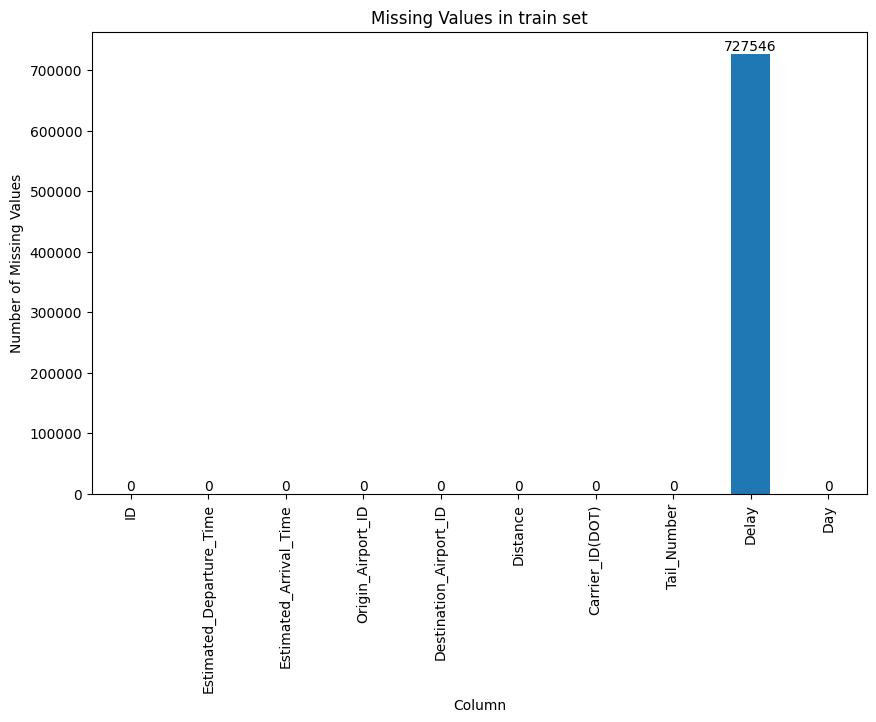

In [ ]:
train_new_fill = train_new[train_new.columns]

missing_values = train_new_fill.isnull().sum()

missing_values.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in train set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

모든 결측치가 다 채워지거나 제거된 것을 볼 수 있다. 우리의 예측 타겟인 Delay는 결측값을 제거할 수 없다. 따라서 라벨링이 되어져 있는 데이터로만 따로 학습을 진행하기로 했다.

In [ ]:
### Dealy 의 NaN 값 제거 (라벨링 된 데이터로만 추론 진행)

train_new = train_new.dropna()

In [ ]:
### Delayed, Not_Delayed 를 0, 1 로 카테고리 화, astype을 쓰지 않은 이유는 변환을 0, 1 로 명확히 하기 위함

train_new['Delay'] = train_new['Delay'].replace('Delayed', 1)
train_new['Delay'] = train_new['Delay'].replace('Not_Delayed', 0)

<ipython-input-24-d34cd49a4bfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['Delay'] = train_new['Delay'].replace('Delayed', 1)


# ***test set 전처리***

In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Estimated_Departure_Time  891016 non-null   float64
 2   Estimated_Arrival_Time    890952 non-null   float64
 3   Cancelled                 1000000 non-null  int64  
 4   Diverted                  1000000 non-null  int64  
 5   Origin_Airport            1000000 non-null  object 
 6   Origin_Airport_ID         1000000 non-null  int64  
 7   Origin_State              893495 non-null   object 
 8   Destination_Airport       1000000 non-null  object 
 9   Destination_Airport_ID    1000000 non-null  int64  
 10  Destination_State         893477 non-null   object 
 11  Distance                  1000000 non-null  float64
 12  Airline                   893473 non-null   object 
 13  Carrier_Code(IATA)        89

test set 도 train set 과 별반 다를 것 없이 결측값을 채워준다. 하지만 없어지는 데이터가 있어선 안되기 때문에 최빈값으로 대체 해 주는 작업을 포함한다.

In [ ]:
### test도 같은 방식으로 진행, 하지만 없어지는 행이 없어야 하기 때문에 최빈값으로 대체하는 작업 필요

carrier_code_mapping2 = test_new.groupby('Airline')['Carrier_ID(DOT)'].apply(lambda x: x.mode().iloc[0])
test_new['Carrier_ID(DOT)'] = test_new['Carrier_ID(DOT)'].fillna(test_new['Airline'].map(carrier_code_mapping2))

In [ ]:
### train set 과 마찬가지로 각각의 지표에 대해 한 번씩 시행

airline_code_mapping2 = test_new.groupby('Carrier_ID(DOT)')['Airline'].apply(lambda x: x.mode().iloc[0])
test_new['Airline'] = test_new['Airline'].fillna(test_new['Carrier_ID(DOT)'].map(airline_code_mapping2))

# test 결측치 시각화 #1

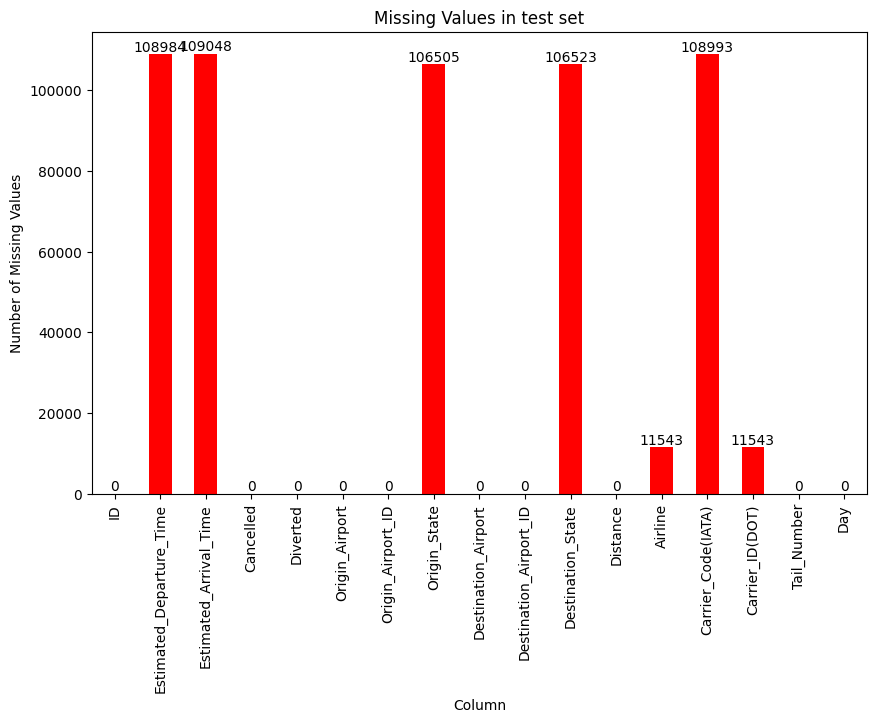

In [ ]:
test_new_fill = test_new[test_new.columns]

missing_values = test_new_fill.isnull().sum()

bar_color = 'red'

missing_values.plot(kind='bar', figsize=(10, 6), color=bar_color)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in test set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom', )

plt.show()

In [ ]:
### 나머지 결측치 대체할 각 컬럼에 대한 최빈값 계산
mode_value = test_new['Carrier_ID(DOT)'].mode().iloc[0]
test_new['Carrier_ID(DOT)'] = test_new['Carrier_ID(DOT)'].fillna(mode_value)

mode_value = test_new['Airline'].mode().iloc[0]
test_new['Airline'] = test_new['Airline'].fillna(mode_value)

Estimated_Departure_Time 과 Estimated_Arrival_Time도 같은 과정을 거친다.

In [ ]:
mode_dep = test_new['Estimated_Departure_Time'].mode().iloc[0]
mode_arr = test_new['Estimated_Arrival_Time'].mode().iloc[0]

test_new['Estimated_Departure_Time'].fillna(mode_dep, inplace=True)
test_new['Estimated_Arrival_Time'].fillna(mode_arr, inplace=True)

다음으로 역시 쓰지 않는 컬럼을 제거 해 준다.

In [ ]:
col_drop = ['Cancelled', 'Diverted', 'Origin_Airport', 'Destination_Airport', 'Carrier_Code(IATA)', 'Airline', 'Origin_State', 'Destination_State']
test_new = test_new.drop(col_drop, axis=1)

test 결측치 시각화 #2

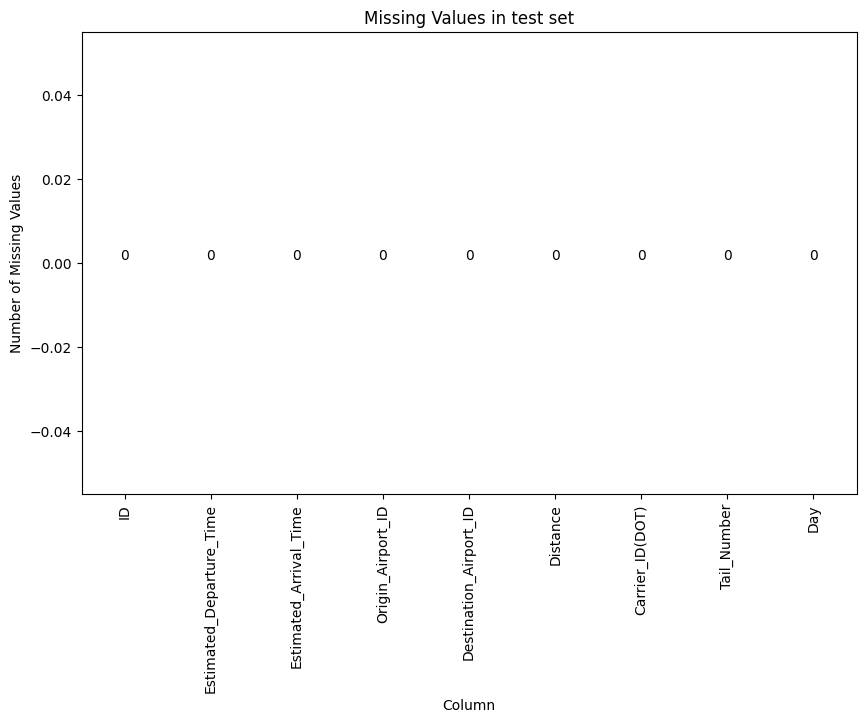

In [ ]:
test_new_fill = test_new[test_new.columns]

missing_values = test_new_fill.isnull().sum()

bar_color = 'red'

missing_values.plot(kind='bar', figsize=(10, 6), color=bar_color)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in test set')

for i, value in enumerate(missing_values):
    plt.text(i, value, str(value), ha='center', va='bottom', )

plt.show()

손실값 없이 모든 데이터들이 잘 채워진 것을 볼 수 있다.

학습을 위해서는 train, test 의 데이터 형이 맞아야 한다. 혹시 모르니 다시 한 번 살펴보자

In [ ]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249021 entries, 5 to 999992
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        249021 non-null  object 
 1   Estimated_Departure_Time  249021 non-null  float64
 2   Estimated_Arrival_Time    249021 non-null  float64
 3   Origin_Airport_ID         249021 non-null  int64  
 4   Destination_Airport_ID    249021 non-null  int64  
 5   Distance                  249021 non-null  float64
 6   Carrier_ID(DOT)           249021 non-null  float64
 7   Tail_Number               249021 non-null  object 
 8   Delay                     249021 non-null  int64  
 9   Day                       249021 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 20.9+ MB


In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Estimated_Departure_Time  1000000 non-null  float64
 2   Estimated_Arrival_Time    1000000 non-null  float64
 3   Origin_Airport_ID         1000000 non-null  int64  
 4   Destination_Airport_ID    1000000 non-null  int64  
 5   Distance                  1000000 non-null  float64
 6   Carrier_ID(DOT)           1000000 non-null  float64
 7   Tail_Number               1000000 non-null  object 
 8   Day                       1000000 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 68.7+ MB


마지막으로 train set이 test set에 비해 약 20프로 정도가 되었기 떄문에  validation set 을 생성해준다. 정확도 향상에도 기여한다.

In [ ]:
X = train_new.drop(columns=['ID', 'Delay'], axis = 1)
y = train_new['Delay']
test_val = test_new.drop(columns=['ID'])
X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y)

# ***모델 구성***

XGBoost는 행렬에 의한 연산으로 모델을 구성한다. 따라서 모두 int, float 타입으로 변형이 되어야 한다. ID 는 오브젝트 형이지만 위에서 삭제되어 버렸다. 그러므로 상관 쓰지 않기로 하고 Tail_Number 와 Day 를 양적변수로 변환해 주기로 한다.

In [ ]:
### xgb 학습을 위해 질적 변수를 양적 변수로 변환함

q_col = ['Tail_Number', 'Day']

for i in q_col:
    le = LabelEncoder()
    le=le.fit(X_train[i])
    X_train[i]=le.transform(X_train[i])

    for label in np.unique(X_valid[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    X_valid[i]=le.transform(X_valid[i])

    for label in np.unique(test_new[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_new[i]=le.transform(test_new[i])
print('Done.')

Done.


In [ ]:
### 모델링

model = XGBClassifier(
                      booster = 'gbtree',
                      scale_pos_weight=5,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.5,
                      max_delta_step = 3,
                      reg_lambda = 2,
                     objective='binary:logistic',
                      n_estimators=818, 
                      max_depth=8,
                     )

In [ ]:
%%time
eval_set = [(X_valid, y_valid)]
eval_metric = ["logloss"]
model.fit(X_train, y_train,early_stopping_rounds=50, eval_metric=eval_metric, eval_set = eval_set)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69273
[1]	validation_0-logloss:0.69227
[2]	validation_0-logloss:0.69189
[3]	validation_0-logloss:0.69146
[4]	validation_0-logloss:0.69114
[5]	validation_0-logloss:0.69077
[6]	validation_0-logloss:0.69037
[7]	validation_0-logloss:0.68985
[8]	validation_0-logloss:0.68944
[9]	validation_0-logloss:0.68896
[10]	validation_0-logloss:0.68856
[11]	validation_0-logloss:0.68818
[12]	validation_0-logloss:0.68785
[13]	validation_0-logloss:0.68746
[14]	validation_0-logloss:0.68713
[15]	validation_0-logloss:0.68679
[16]	validation_0-logloss:0.68643
[17]	validation_0-logloss:0.68633
[18]	validation_0-logloss:0.68600
[19]	validation_0-logloss:0.68569
[20]	validation_0-logloss:0.68543
[21]	validation_0-logloss:0.68514
[22]	validation_0-logloss:0.68489
[23]	validation_0-logloss:0.68461
[24]	validation_0-logloss:0.68430
[25]	validation_0-logloss:0.68399
[26]	validation_0-logloss:0.68374
[27]	validation_0-logloss:0.68349
[28]	validation_0-logloss:0.68315
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
predictions = model.predict_proba(X_valid)
predictions

array([[0.57460064, 0.42539936],
       [0.32181174, 0.67818826],
       [0.59278274, 0.40721723],
       ...,
       [0.37149364, 0.62850636],
       [0.50608945, 0.49391052],
       [0.4700411 , 0.5299589 ]], dtype=float32)

validation set 과 같이 test set 에서도 ID 를 떼어준 뒤 예측시킨다.

In [ ]:
test_new = test_new.drop('ID', axis = 1)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199216 entries, 184087 to 688111
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Estimated_Departure_Time  199216 non-null  float64
 1   Estimated_Arrival_Time    199216 non-null  float64
 2   Origin_Airport_ID         199216 non-null  int64  
 3   Destination_Airport_ID    199216 non-null  int64  
 4   Distance                  199216 non-null  float64
 5   Carrier_ID(DOT)           199216 non-null  float64
 6   Tail_Number               199216 non-null  int64  
 7   Day                       199216 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 13.7 MB


In [ ]:
predictions = model.predict_proba(test_new)
predictions

array([[0.49276125, 0.50723875],
       [0.50178194, 0.49821806],
       [0.6410568 , 0.35894322],
       ...,
       [0.5396868 , 0.46031317],
       [0.5213657 , 0.4786343 ],
       [0.40867245, 0.59132755]], dtype=float32)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dakondata/sample_submission.csv', index_col = 0)

In [ ]:
submission = pd.DataFrame(data=predictions, columns=sample_submission.columns, index=sample_submission.index)

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dakondata/sample_submission2.csv', index=True)

In [ ]:
submission.tail()

,Not_Delayed,Delayed
ID,,
TEST_999995,0.688260,0.311740
TEST_999996,0.627096,0.372904
TEST_999997,0.539687,0.460313
TEST_999998,0.521366,0.478634
TEST_999999,0.408672,0.591328
